In [1]:
import torch, detectron2
from helpers.helper import Helper
from pathlib import Path
import copy
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2. __version__)
nc = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()

torch:  2.0 ; cuda:  cu117
detectron2: 0.6


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm
import torch
import logging

class ValidationLoss(HookBase):
    """
    A hook that computes validation loss during training.

    Attributes:
        cfg (CfgNode): The detectron2 config node.
        _loader (iterator): An iterator over the validation dataset.
    """

    def __init__(self, cfg,
                 metric   = "segm/AP50", 
                 min_max  = "max"):
        """
        Args:
            cfg (CfgNode): The detectron2 config node.
        """
        super().__init__()
        self.cfg = cfg.clone()
        # Switch to the validation dataset
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.TEST
        # Build the validation data loader iterator
        self._loader = iter(build_detection_train_loader(self.cfg))
        #best accuracy calculate
        self._period = cfg.TEST.EVAL_PERIOD
        self.metric = metric
        self.min_max = min_max
        self.best_value = float("-inf") if min_max == "max" else float("inf")
        logger = logging.getLogger("detectron2")
        logger.setLevel(logging.DEBUG)
        logger.propagate = False
        self._logger = logger
    
    def _take_latest_metrics(self):
      with torch.no_grad():
        latest_metrics = self.trainer.storage.latest()
        return latest_metrics
    
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
          latest_metrics = self._take_latest_metrics()
          for (key, (value, iter)) in latest_metrics.items():
            if key == self.metric:
              if (self.min_max == "min" and value < self.best_value) or (self.min_max == "max" and value > self.best_value):
                self._logger.info("Updating best model at iteration {} with {} = {}".format(iter, self.metric, value))
                self.best_value = value
                self.trainer.checkpointer.save("model_best")
        """
        Computes the validation loss after each training step.
        """
        # Get the next batch of data from the validation data loader
        data = next(self._loader)
        with torch.no_grad():
            # Compute the validation loss on the current batch of data
            loss_dict = self.trainer.model(data)

            # Check for invalid losses
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            # Reduce the loss across all workers
            loss_dict_reduced = {"val_" + k: v.item() for k, v in
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            # Save the validation loss in the trainer storage
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced,
                                                 **loss_dict_reduced)

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.engine import DefaultTrainer
# import some common libraries
import numpy as np
import cv2
import random
import os
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
cur_dir = os.getcwd()
# dataset path

data_dir = r"D:\Nyi Zaw Aung\815_CowDataChecking\Sumiyoshi ToAnnotate\September 2025"
training_dataset_name = "training_data"
training_json_file = os.path.join(data_dir, "training_images\\0_SideLane_addedversion_Training_COCO.json")
training_img_dir = os.path.join(data_dir, "training_images")
register_coco_instances(training_dataset_name, {}, training_json_file, training_img_dir)

test_dataset_name = "test_data"
test_json_file =  os.path.join(data_dir, "testing_images\\0_SideLane_addedversion_Testing_COCO.json")
test_img_dir =  os.path.join(data_dir, "testing_images")
register_coco_instances(test_dataset_name, {}, test_json_file, test_img_dir)

#val_dataset_name = "val_data"
#val_json_file =  os.path.join(data_dir, "validation_annotations_coco.json")
#val_img_dir =  os.path.join(data_dir, "validation_images")
#register_coco_instances(val_dataset_name, {}, val_json_file, val_img_dir)
# output weight file


In [5]:
max_iter = 20000
weight_output = str(Helper.increment_path(Path('models') /'Side Lane September 2025'/ f'Base_rtx8000_26_September_2025_{max_iter}_v',mkdir=True))

In [6]:
cfg = get_cfg()
cfg.MODEL.MASK_ON = True
# Create a configuration and set up the model and datasets
#model_file = "models\\December 2024\\Sumiyoshi_dec16_v2_human_2024_10000_iters_v1"
#model_file = "models\\April 2025\\April_Day_Night_10000_iters_v1" #Sumiyoshi_2024_10000_iters_v4
#model_file = "models\May 2025\KNP_Sumi_26_May_2025_10000_v1" #latest v3 not so go accuracy
model_file = "models\\Side Lane August 2025\Base_rtx8000_10_August_2025_20000_v1"
#loading initial configuration file (can change here with above model file or previous dataset weight to update)
cfg.merge_from_file(f"{model_file}\\config.yml")
#loading initial weight file
cfg.MODEL.WEIGHTS = f"{model_file}\\model_best.pth"

#base weight file 
#model_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
#cfg.merge_from_file(model_zoo.get_config_file(model_file)) 
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_file)

#set dataset
cfg.DATASETS.TRAIN = (training_dataset_name,)
cfg.DATASETS.TEST = (test_dataset_name,)
# cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN = 2500
# cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST = 1500
# Workers
cfg.DATALOADER.NUM_WORKERS = 8
# Options: TrainingSampler, RepeatFactorTrainingSampler
cfg.DATALOADER.SAMPLER_TRAIN = "TrainingSampler"
# Repeat threshold for RepeatFactorTrainingSampler
cfg.DATALOADER.REPEAT_THRESHOLD = 0.3
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False

# cfg.MODEL.FPN.NORM = "GN"
# cfg.MODEL.FPN.FUSE_TYPE = "avg"

# cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RPN"
# cfg.MODEL.ROI_MASK_HEAD.NORM = "GN"
# Solver
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.0025 #0.0025
cfg.SOLVER.WARMUP_ITERS = 2000 #5-10% of 
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.STEPS = (8000, 16000) #
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.MAX_ITER = max_iter
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"  # Use the warmup scheduler
# checkpoint
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
#[192.02035868 119.79467167 169.64932096 150.05893666 220.94671905]
#ratios [0.73263128 1.5411869  0.45270707]
#cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[215.62343506,  86.09196645, 155.51176415, 184.45140588, 122.96515762]]  #sumiyoshi 07 feb 2025
#cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [0.68256319, 0.45821762, 1.49434463]  #sumiyoshi 07 feb 2025
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[149.95695869, 90.25478231, 179.26082761, 119.37182681, 213.92048847]] #sumiyoshi 07 feb 2025
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [1.36056301, 0.71964180, 0.44608757] #sumiyoshi 07 feb 2025
#sizes [149.95695869, 90.25478231, 179.26082761, 119.37182681, 213.92048847]
#ratios [1.36056301, 0.71964180, 0.44608757]


cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = weight_output

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
for fname in os.listdir(cfg.OUTPUT_DIR):
    if "tfevents" in fname:
        os.remove(os.path.join(cfg.OUTPUT_DIR, fname))
print(cfg.dump())    
f = open(f'{weight_output}\\config.yml', 'w')
f.write(cfg.dump())
f.close()

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: false
  NUM_WORKERS: 8
  REPEAT_SQRT: true
  REPEAT_THRESHOLD: 0.3
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - test_data
  TRAIN:
  - training_data
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - 1.36056301
    - 0.7196418
    - 0.44608757
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 149.95695869
      - 90.25478231
      - 179.26082761
      - 119.371

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
from detectron2.data import build_detection_train_loader
class MyTrainer(DefaultTrainer):
  @classmethod
  def build_train_loader(cls, cfg):
    
        augs = []
        # Aug 1: Add RandomBrightness with 50% chance
        augs.append(
            T.RandomApply(
              T.RandomBrightness(
                  intensity_min = 0.5,
                  intensity_max = 1.5),
              prob = 0.5
            ))
        augs.append(
            T.RandomApply(
              T.RandomSaturation(
                  intensity_min = 0.5,
                  intensity_max = 1.5),
              prob = 0.5
            ))
            
        augs.append(T.RandomApply(T.RandomRotation(
               angle         = [-30, 30],
               sample_style  = "range",
               center        = [[0.4, 0.6], [0.4, 0.6]],
               expand        = False
             ), prob=0.5))
        # Aug 2: Add ResizeShortestEdge
        min_size = cfg.INPUT.MIN_SIZE_TRAIN
        max_size = cfg.INPUT.MAX_SIZE_TRAIN
        sample_style = cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        augs.append(T.ResizeShortestEdge(
                min_size, 
                max_size, 
                sample_style)
            )

        # Aug 3: Add RandomFlipping
        if cfg.INPUT.RANDOM_FLIP != "none":
              augs.append(T.RandomFlip(
              horizontal=cfg.INPUT.RANDOM_FLIP == "horizontal",
              vertical=cfg.INPUT.RANDOM_FLIP == "vertical",
            )
          )
        data_loader = build_detection_train_loader(cfg,
            mapper=DatasetMapper(cfg, is_train=True, 
                                 augmentations=augs))
        
        #return build_detection_train_loader(cfg, mapper=custom_mapper) 
        return data_loader
  
  #@classmethod
  #def build_test_loader(cls, cfg, dataset_name):
  #  return build_test_loader_with_mosaic(cfg, dataset_name)
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder == None:
      output_folder = cfg.OUTPUT_DIR
    else:
      output_folder = os.path.join(cfg.OUTPUT_DIR, output_folder)
      os.makedirs(output_folder)
    # Use 
    return COCOEvaluator(dataset_name, distributed=False, output_dir=output_folder)

In [9]:
import cv2
import numpy as np
from detectron2.data import detection_utils as utils


def mosaic_augmentation(dataset_dicts, image_size=(1024, 1024)):
    """Applies Mosaic augmentation to a dataset."""
    num_images = len(dataset_dicts)
    mosaic_image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    mosaic_annotations = []

    # Randomly select 4 images
    indices = np.random.choice(num_images, 4, replace=False)
    offsets = [
        (0, 0),
        (0, image_size[1] // 2),
        (image_size[0] // 2, 0),
        (image_size[0] // 2, image_size[1] // 2),
    ]

    for i, idx in enumerate(indices):
        dataset_dict = dataset_dicts[idx]
        image = utils.read_image(dataset_dict["file_name"], format="BGR")
        h, w = image.shape[:2]

        # Resize the image to fit into the mosaic
        resized_image = cv2.resize(image, (image_size[1] // 2, image_size[0] // 2))
        x_offset, y_offset = offsets[i]
        mosaic_image[y_offset:y_offset + resized_image.shape[0], x_offset:x_offset + resized_image.shape[1]] = resized_image

        # Adjust annotations
        if "annotations" in dataset_dict:
            for annotation in dataset_dict["annotations"]:
                bbox = annotation["bbox"]
                # Scale bounding box
                bbox = [
                    bbox[0] * resized_image.shape[1] / w + x_offset,
                    bbox[1] * resized_image.shape[0] / h + y_offset,
                    bbox[2] * resized_image.shape[1] / w + x_offset,
                    bbox[3] * resized_image.shape[0] / h + y_offset,
                ]
                annotation["bbox"] = bbox
                mosaic_annotations.append(annotation)

    return {
        "image": mosaic_image,
        "annotations": mosaic_annotations,
    }


In [10]:
from detectron2.data import build_detection_test_loader

def build_test_loader_with_mosaic(cfg, dataset_name):
    return build_detection_test_loader(
        cfg, dataset_name, mapper=test_mapper_with_mosaic
    )


In [11]:

def test_mapper_with_mosaic(dataset_dict):
    # Read the image
    dataset_dict = copy.deepcopy(dataset_dict)  # Ensure the original dict is not modified
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    # Apply Mosaic Augmentation or other transformations
    transform_list = [
        T.Resize((800, 800)),  # Example: Resize the image
        T.RandomRotation([-30, 30]),  # Example: Random rotation
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    
    # Update the dataset dictionary with the transformed image
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1))  # Convert to Tensor
    return dataset_dict


In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from detectron2.layers import batched_nms
from detectron2.structures import Boxes, Instances
from typing import Callable, Dict, List, Optional, Tuple, Union

# rebuild
def _inference(self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]):
        boxes = self.predict_boxes(predictions, proposals)
        scores = self.predict_probs(predictions, proposals)
        image_shapes = [x.image_size for x in proposals]
        return fast_rcnn_inference(
            boxes,
            scores,
            image_shapes,
            self.test_score_thresh,
            self.test_nms_thresh,
            self.test_topk_per_image,
        )

def fast_rcnn_inference(
    boxes: List[torch.Tensor],
    scores: List[torch.Tensor],
    image_shapes: List[Tuple[int, int]],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    result_per_image = [
        fast_rcnn_inference_single_image(
            boxes_per_image, scores_per_image, image_shape, score_thresh, nms_thresh, topk_per_image
        )
        for scores_per_image, boxes_per_image, image_shape in zip(scores, boxes, image_shapes)
    ]
    return [x[0] for x in result_per_image], [x[1] for x in result_per_image]

def fast_rcnn_inference_single_image(
    boxes,
    scores,
    image_shape: Tuple[int, int],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    valid_mask = torch.isfinite(boxes).all(dim=1) & torch.isfinite(scores).all(dim=1)
    if not valid_mask.all():
        boxes = boxes[valid_mask]
        scores = scores[valid_mask]

    scores = scores[:, :-1]
    num_bbox_reg_classes = boxes.shape[1] // 4
    # Convert to Boxes to use the `clip` function ...
    boxes = Boxes(boxes.reshape(-1, 4))
    boxes.clip(image_shape)
    boxes = boxes.tensor.view(-1, num_bbox_reg_classes, 4)  # R x C x 4

    # 1. Filter results based on detection scores. It can make NMS more efficient
    #    by filtering out low-confidence detections.
    filter_mask = scores > score_thresh  # R x K
    # R' x 2. First column contains indices of the R predictions;
    # Second column contains indices of classes.
    filter_inds = filter_mask.nonzero()
    if num_bbox_reg_classes == 1:
        boxes = boxes[filter_inds[:, 0], 0]
    else:
        boxes = boxes[filter_mask]
    scores = scores[filter_mask]

    # begin of changes
    # 2. Apply NMS for all classes.
    filter_inds1 = torch.ones_like(filter_inds) # make them all same class
    keep = batched_nms(boxes, scores, filter_inds1[:,1] , nms_thresh)
    # end of changes
    if topk_per_image >= 0:
        keep = keep[:topk_per_image]
    boxes, scores, filter_inds = boxes[keep], scores[keep], filter_inds[keep]

    result = Instances(image_shape)
    result.pred_boxes = Boxes(boxes)
    result.scores = scores
    result.pred_classes = filter_inds[:, 1]
    return result, filter_inds[:, 0]

In [13]:
import types
trainer = MyTrainer(cfg)
trainer.model.roi_heads.box_predictor.inference = types.MethodType(_inference, trainer.model.roi_heads.box_predictor)
bm_hook = ValidationLoss(cfg, 
                        metric  = "segm/AP50", 
                        min_max = "max")
trainer.register_hooks(hooks=[bm_hook])
# Swap the positions of the evaluation and checkpointing hooks so that the validation loss is logged correctly
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

[09/26 14:05:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [14]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

def imshow(image):
  dpi = plt.rcParams["figure.dpi"]
  im_data = image[:,:, ::-1]
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  plt.imshow(im_data)
  plt.imshow(im_data)
  plt.axis("off")
  plt.show()

def visualize_image_boxes(img,masks,boxes,labels,colors=['r','g','b']):
  v = Visualizer(img, metadata={})
  v = v.overlay_instances(
      masks=masks,
      boxes=boxes, 
      labels=labels,
      assigned_colors=colors*len(boxes)
      )
  im_data = v.get_image()
  imshow(im_data)
  
def visualize_sample(sample):
  img = sample['image'].to("cpu").numpy()
  img = np.moveaxis(img, 0, -1)
  masks = sample['instances'].get('gt_masks')  
  boxes = sample['instances'].get('gt_boxes')
  labels = sample['instances'].get('gt_classes').to("cpu").numpy()
  visualize_image_boxes(img,masks, boxes,labels)

In [15]:
# display 2 training batch
# import numpy as np
# tli = iter(trainer.data_loader)
# for i in range(2):
#   batch = next(tli)
#   for sample in batch:
#     visualize_sample(sample)

In [16]:
trainer.resume_or_load(resume=False)
trainer.train()

[09/26 14:05:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models\Side Lane August 2025\Base_rtx8000_10_August_2025_20000_v1\model_best.pth ...
[09/26 14:05:28 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\choni\anaconda3\envs\clone_from_super_venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/26 14:06:21 d2.utils.events]:  eta: 8:22:30  iter: 19  total_loss: 0.5444  loss_cls: 0.05023  loss_box_reg: 0.1006  loss_mask: 0.0839  loss_rpn_cls: 0.1114  loss_rpn_loc: 0.2113  total_val_loss: 0.4867  val_loss_cls: 0.04023  val_loss_box_reg: 0.08127  val_loss_mask: 0.08432  val_loss_rpn_cls: 0.04277  val_loss_rpn_loc: 0.2271    time: 1.4992  last_time: 1.4380  data_time: 0.1451  last_data_time: 0.0078   lr: 2.6226e-05  max_mem: 15214M
[09/26 14:07:04 d2.utils.events]:  eta: 8:27:06  iter: 39  total_loss: 0.5557  loss_cls: 0.04903  loss_box_reg: 0.09777  loss_mask: 0.09179  loss_rpn_cls: 0.1173  loss_rpn_loc: 0.1993  total_val_loss: 0.4214  val_loss_cls: 0.03555  val_loss_box_reg: 0.06605  val_loss_mask: 0.08324  val_loss_rpn_cls: 0.03267  val_loss_rpn_loc: 0.1979    time: 1.5153  last_time: 1.6086  data_time: 0.0074  last_data_time: 0.0065   lr: 5.1201e-05  max_mem: 15214M
[09/26 14:07:49 d2.utils.events]:  eta: 8:28:14  iter: 59  total_loss: 0.492  loss_cls: 0.0499  loss_box_reg

In [17]:
from detectron2.engine import DefaultPredictor
#weight_output = "models\\March 2025\\Feb_March_Day_Night_15000_iters_v2" #model testing, remove 
cfg.merge_from_file(f"{weight_output}\\config.yml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST  = 0.6
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.MODEL.WEIGHTS = os.path.join(weight_output,"model_final.pth")
predictor = DefaultPredictor(cfg)

[09/27 02:58:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models\Side Lane September 2025\Base_rtx8000_26_September_2025_20000_v1\model_final.pth ...


In [18]:
import random
random.seed(42)
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

def plot_samples(samples, 
                 met        = {}, 
                 is_gt      = True, 
                 predictor  = None):
  n = len(samples)
  nrows = int(-(-n/3)) # ceil
  ncols = 3
  fig, axs = plt.subplots(nrows   = nrows, 
                          ncols   = ncols, 
                          figsize = (21, 7))
  for i,s in enumerate(samples):
    row = i//ncols
    col = i%ncols
    ax = axs[row][col] if len(axs.shape)==2 else axs[i]
    img = cv2.imread(s["file_name"])
    v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5)
    if is_gt:
      # visualize ground-truths
      v = v.draw_dataset_dict(s)
    else:
      # predict
      outputs = predictor(img)
      # visualize prediction results
      instances = outputs["instances"].to("cpu")
      v = v.draw_instance_predictions(instances)

    ax.imshow(v.get_image())
    ax.axis("off")
  plt.tight_layout()
  plt.show()

def plot_random_samples(name_ds, n=3, predictor=None):
  # access
  ds = DatasetCatalog.get(name_ds)
  met = MetadataCatalog.get(name_ds)
  samples = random.sample(ds, n)
  # plot samples with ground-truths
  plot_samples(samples, met)
  # plot predictions
  plot_samples(samples, 
               met        = met, 
               predictor  = predictor, 
               is_gt      = False)

In [19]:
#plot_random_samples(test_dataset_name, predictor = predictor)

In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor
from detectron2.data import build_detection_test_loader
# update newly trained weight file here
#cfg.MODEL.WEIGHTS = f"models\\April 2025\April_Day_Night_10000_iters_v2\\model_final.pth"

print(cfg.MODEL.WEIGHTS)
model_type="maskrcnn"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.DATASETS.TEST=(test_dataset_name,)
predictor=DefaultPredictor(cfg)
if model_type == "maskrcnn":
    eval_tasks = ("segm",)
elif model_type == "retinanet":
    eval_tasks = ("bbox",)
    
evaluator = COCOEvaluator(test_dataset_name,cfg,
                          distributed=False,
                          output_dir=weight_output)


trainer.test(cfg, predictor.model, evaluators=evaluator)  # testing dataset

models\Side Lane September 2025\Base_rtx8000_26_September_2025_20000_v1\model_final.pth
[09/27 02:58:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models\Side Lane September 2025\Base_rtx8000_26_September_2025_20000_v1\model_final.pth ...
[09/27 02:58:38 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [09/27 02:58:38 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/27 02:58:38 d2.data.datasets.coco]: Loaded 566 images in COCO format from D:\Nyi Zaw Aung\815_CowDataChecking\Sumiyoshi ToAnnotate\September 2025\testing_images\0_SideLane_addedversion_Testing_COCO.json
[09/27 02:58:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/27 02:58:38 d2.data.common]: Serializing the dataset usin

OrderedDict([('bbox',
              {'AP': 92.52802260880163,
               'AP50': 98.01886438643864,
               'AP75': 98.00971723449445,
               'APs': nan,
               'APm': 92.57892622146531,
               'APl': 92.85030556856351,
               'AP-cow': 92.52802260880163,
               'AP-background': nan}),
             ('segm',
              {'AP': 85.29519638092074,
               'AP50': 98.01886438643864,
               'AP75': 97.96348428726671,
               'APs': nan,
               'APm': 82.40203457036547,
               'APl': 87.43856856684276,
               'AP-cow': 85.29519638092074,
               'AP-background': nan})])

In [21]:
from detectron2.evaluation import COCOEvaluator, pascal_voc_evaluation
from detectron2.engine import DefaultPredictor

# update newly trained weight file here
#cfg.MODEL.WEIGHTS = f"{weight_output}\\model_final.pth"

print(cfg.MODEL.WEIGHTS)
model_type="maskrcnn"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.DATASETS.TEST=(training_dataset_name,)
predictor=DefaultPredictor(cfg)
if model_type == "maskrcnn":
    eval_tasks = ("segm",)
elif model_type == "retinanet":
    eval_tasks = ("bbox",)
    
evaluator = COCOEvaluator(training_dataset_name,cfg,
                          distributed=False,
                          output_dir=weight_output)


trainer.test(cfg, predictor.model, evaluators=evaluator)  # trainer

models\Side Lane September 2025\Base_rtx8000_26_September_2025_20000_v1\model_final.pth
[09/27 02:59:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models\Side Lane September 2025\Base_rtx8000_26_September_2025_20000_v1\model_final.pth ...
[09/27 02:59:25 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [09/27 02:59:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/27 02:59:26 d2.data.datasets.coco]: Loaded 2260 images in COCO format from D:\Nyi Zaw Aung\815_CowDataChecking\Sumiyoshi ToAnnotate\September 2025\training_images\0_SideLane_addedversion_Training_COCO.json
[09/27 02:59:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/27 02:59:27 d2.data.common]: Serializing the dataset u

OrderedDict([('bbox',
              {'AP': 95.73406891364596,
               'AP50': 98.01968983850475,
               'AP75': 98.00887171462344,
               'APs': nan,
               'APm': 95.31791277157325,
               'APl': 96.1161283990425,
               'AP-cow': 95.73406891364596,
               'AP-background': nan}),
             ('segm',
              {'AP': 87.14753194867284,
               'AP50': 98.01968983850475,
               'AP75': 97.97787475003868,
               'APs': nan,
               'APm': 84.67012826607439,
               'APl': 88.62166489358756,
               'AP-cow': 87.14753194867284,
               'AP-background': nan})])

In [22]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.engine import DefaultPredictor
# from detectron2.data import build_detection_test_loader
# # update newly trained weight file here
# #cfg.MODEL.WEIGHTS = f"{weight_output}\\model_final.pth"

# print(cfg.MODEL.WEIGHTS)
# model_type="maskrcnn"
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
# predictor=DefaultPredictor(cfg)
# if model_type == "maskrcnn":
#     eval_tasks = ("segm",)
# elif model_type == "retinanet":
#     eval_tasks = ("bbox",)
    
# evaluator = COCOEvaluator(val_dataset_name,cfg,
#                           distributed=False,
#                           output_dir=weight_output)

# val_loader = build_detection_test_loader(cfg,val_dataset_name)
# inference_on_dataset(trainer.model,val_loader,evaluator)

import ast
import json

import matplotlib.pyplot as plt
import numpy as np


def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#weight_output = "models\model_4000_iter1" #iter1 is the best for now
#weight_output = "models\model_4000iter1_6000_iter8" #iter1 is the best for now
#weight_output = "models\\base_yoshii_model_Sumiyoshi_anchor_v1_15000_iters2"
metrics_file = f'{weight_output}\\metrics.json'
print(metrics_file)

with open(metrics_file, 'r') as f:
    metrics = [eval(l[:-1].replace('NaN','0')) for l in f.readlines()]
    f.close()

train_loss = [float(v['loss_box_reg']) for v in metrics if 'loss_box_reg' in v.keys()]
val_loss = [float(v['val_loss_box_reg']) for v in metrics if 'val_loss_box_reg' in v.keys()]

N = 40

train_loss_avg = moving_average(train_loss, n=N)
val_loss_avg = moving_average(val_loss, n=N)

plt.plot(range(20 * N - 1, 20 * len(train_loss), 20), train_loss_avg, label='train loss')
plt.plot(range(20 * N - 1, 20 * len(train_loss), 20), val_loss_avg, label='val loss')
plt.legend()
plt.grid()
plt.show()

models\Side Lane September 2025\Base_rtx8000_26_September_2025_20000_v1\metrics.json


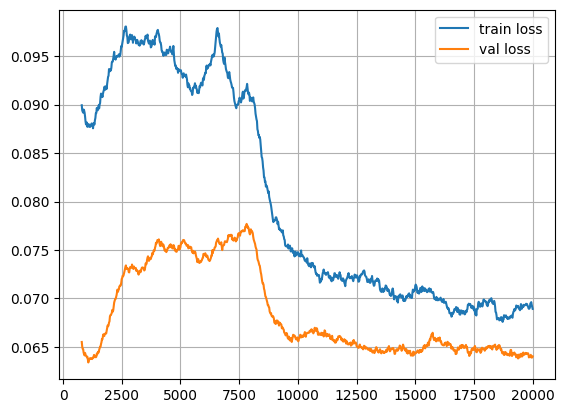

In [23]:
import ast
import json

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#weight_output = "models\model_4000_iter1" #iter1 is the best for now
#weight_output = "models\model_4000iter1_6000_iter8" #iter1 is the best for now

#weight_output = "models\\Side Lane June 2025\Base_rtx8000_25_June_2025_5000_v1"
metrics_file = f'{weight_output}\\metrics.json'
print(metrics_file)

with open(metrics_file, 'r') as f:
    metrics = [eval(l[:-1].replace('NaN','0')) for l in f.readlines()]
    f.close()

train_loss = [float(v['loss_box_reg']) for v in metrics if 'loss_box_reg' in v.keys()]
val_loss = [float(v['val_loss_box_reg']) for v in metrics if 'val_loss_box_reg' in v.keys()]

N = 40

train_loss_avg = moving_average(train_loss, n=N)
val_loss_avg = moving_average(val_loss, n=N)

plt.plot(range(20 * N - 1, 20 * len(train_loss), 20), train_loss_avg, label='train loss')
plt.plot(range(20 * N - 1, 20 * len(train_loss), 20), val_loss_avg, label='val loss')
plt.legend()
plt.grid()
plt.show()